In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
g = nx.DiGraph()

In [22]:
connected_comp = list(nx.strongly_connected_components(g))

In [24]:
maximum = 0
maximum_element = {}
for element in connected_comp:
  if len(element) > maximum:
    maximum = len(element)
    maximum_element = element

In [32]:
with open("data/higgs-mention_network.edgelist", "r") as file:
  with open("data/higgs-mention_network_filtered.edgelist", "w") as filtered_file:
    for line in file:
      items = line.split(" ")
      if items[0] in maximum_element and items[1] in maximum_element:
          filtered_file.write(line)

In [33]:
with open("data/higgs-reply_network.edgelist", "r") as file:
  with open("data/higgs-reply_network_filtered.edgelist", "w") as filtered_file:
    for line in file:
      items = line.split(" ")
      if items[0] in maximum_element and items[1] in maximum_element:
          filtered_file.write(line)

In [34]:
with open("data/higgs-retweet_network.edgelist", "r") as file:
  with open("data/higgs-retweet_network_filtered.edgelist", "w") as filtered_file:
    for line in file:
      items = line.split(" ")
      if items[0] in maximum_element and items[1] in maximum_element:
          filtered_file.write(line)

In [35]:
with open("data/higgs-social_network.edgelist", "r") as file:
  with open("data/higgs-social_network_filtered.edgelist", "w") as filtered_file:
    for line in file:
      items = line.split(" ")
      if items[0] in maximum_element and items[1] in maximum_element:
          filtered_file.write(line)

In [36]:
with open("data/higgs-activity_time.txt", "r") as file:
  with open("data/higgs-activity_time_filtered.txt", "w") as filtered_file:
    for line in file:
      items = line.split(" ")
      if items[0] in maximum_element and items[1] in maximum_element:
          filtered_file.write(line)

In [37]:
with open("data/higgs-social_network_filtered.edgelist") as file:
  for line in file:
    v, u = line.strip('\n').split(" ")
    g.add_edge(v, u)

In [38]:
n = len(g.nodes)
e = len(g.edges)
average_degree = e / n

In [39]:
print("Grado promedio {}".format(average_degree))

Grado promedio 32.53393805871764


In [40]:
degrees = nx.degree(g)
degrees = dict(degrees)

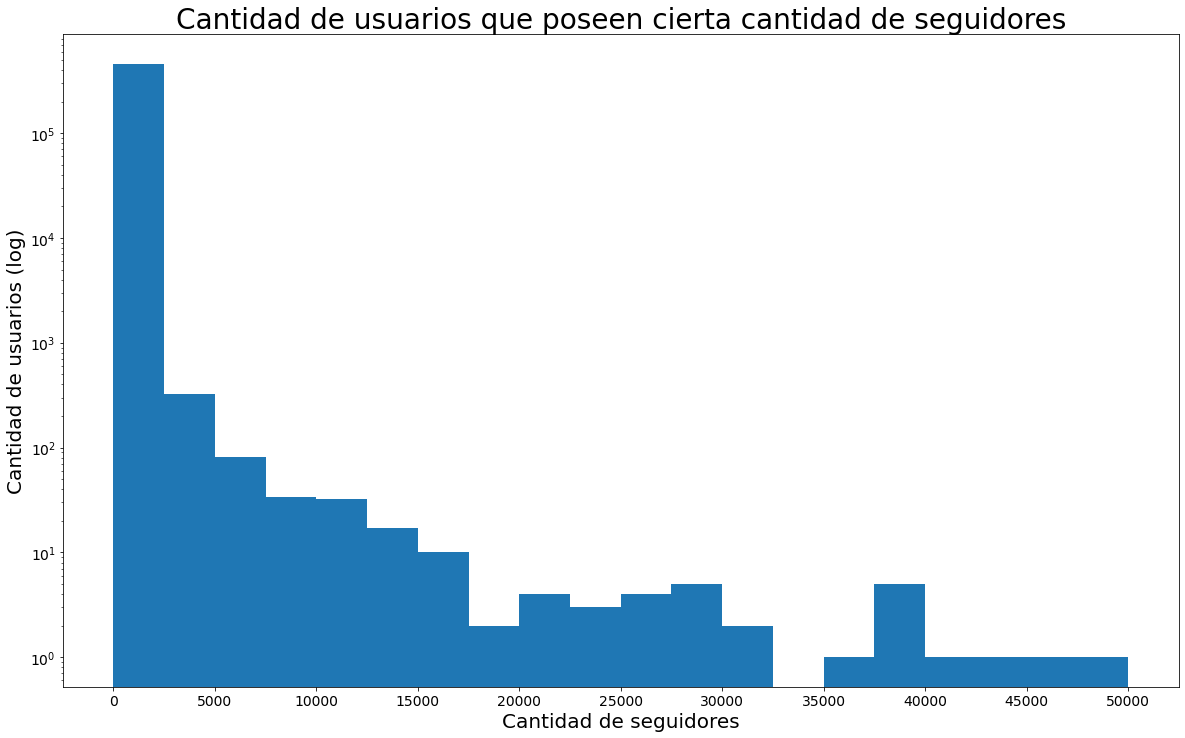

In [41]:
bins = np.arange(-0.5, 51000, 2500)

plt.figure(figsize=(20,12))
plt.hist(list(degrees.values()), bins=bins, log=True)
plt.xlabel("Cantidad de seguidores", size=20)
plt.ylabel("Cantidad de usuarios (log)", size=20)
plt.xticks(range(0, 55000, 5000), fontsize=14)
plt.yticks(fontsize=14)
plt.title("Cantidad de usuarios que poseen cierta cantidad de seguidores", fontsize=28)

plt.show()